# Network is a 3 fully connected hidden layer network for detecting the images of cats. This is  a full pipeline with the model, training and evaluation using Kaggle Cat and Dogs dataset.

In [1]:
#Start with cheking if GPUs are avalible

import tensorflow as tf

# Check if GPUs are availible:
if tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None):
     print("GPU is available.")
else:
     print("GPU is not available.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available.


2023-08-31 10:56:22.282678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 10:56:22.473652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-31 10:56:22.473801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-31 10:56:22.499328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [2]:
#Download Toloka cats and dogs toy datase (https://www.kaggle.com/datasets/valentinbiryukov/toloka-cats-and-dogs-toy-dataset) from Kaggle to local directory.
#Load it to Jupyter notebook

import os

file_name = "/home/semc/Aygul_DL/archive.zip"  # location and name of data file
file_size = os.path.getsize(file_name)

print(f'User uploaded file "{file_name}" with length {file_size} bytes')

User uploaded file "/home/semc/Aygul_DL/archive.zip" with length 4464 bytes


In [3]:
# Work with zipped file using pandas

import pandas as pd

# Reading from a zipped CSV file:
data = pd.read_csv(file_name, compression='zip', encoding='utf-8', header=0, sep='\t')

# Display the first few rows to understand the structure:
data.head()

,url,label
0,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog
1,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog
2,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog
3,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog
4,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog


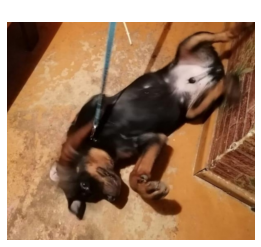

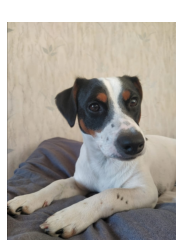

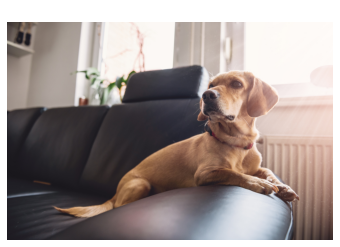

In [4]:
# Show some images with the labels

import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Assuming 'url' is the column containing the URLs to the images
# and 'label' is the column containing the labels:
for url, label in zip(data['url'][:3], data['label'][:3]):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    plt.imshow(image)
    plt.axis('off') # To remove axes
    plt.title(f'Label: {label}', color='white') # Display the label as the title
    plt.show()

/tmp/ipykernel_1257659/2391142628.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for url, label in zip(train_data['url'][:3], train_data['label'][:3]):


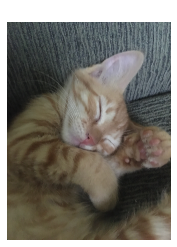

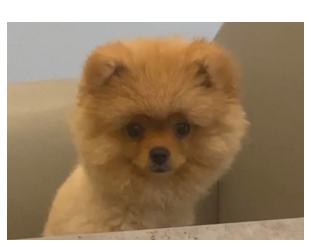

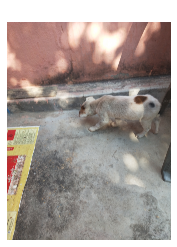

In [5]:
# Split the data to trainig and testing datasets

from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# You can now access the training and testing sets as separate DataFrames
# For example, to display the first three images and labels from the training set:
for url, label in zip(train_data['url'][:3], train_data['label'][:3]):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    plt.imshow(image)
    plt.axis('off') # To remove axes
    plt.title(f'Label: {label}', color='white') # Display the label as the title
    plt.show()

In [6]:
#Function for normalizing and resizing images:
from PIL import Image

def normalize_and_resize_image(url, shape=(224, 224)):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).resize(shape)
    image_array = np.array(image)
    return image_array / 255.0

#Function for downloading and preprocessing images in parallele to speed up the process:
from concurrent.futures import ThreadPoolExecutor
import numpy as np

def download_and_preprocess_images(image_urls):
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(normalize_and_resize_image, image_urls))
    return np.stack(images)

In [7]:
# Download and preprocess trainig data (X)

train_image_urls = train_data['url'].values
test_image_urls = test_data['url'].values

X_train = download_and_preprocess_images(train_image_urls)
X_test = download_and_preprocess_images(test_image_urls)

In [8]:
# Convert labels (cat, dog) to integegs
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object:
le = LabelEncoder()

# Fit the encoder on the labels in data (both train an test) to know what unique labels exist and convert labels to integers:
le.fit(data['label'])

# Transform both the training and test labels into integers:
y_train = le.transform(train_data['label'])
y_test = le.transform(test_data['label'])

In [9]:
# Architecture of neural network with 3 fully connected hidden layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential([
    Flatten(input_shape=(224, 224, 3)),                # Input layer: Flatten the 224x224x3 images
    Dense(64, activation='relu'),                      # Hidden layer 1
    Dense(64, activation='relu'),                      # Hidden layer 2
    Dense(64, activation='relu'),                      # Hidden layer 3
    Dense(1, activation='sigmoid')                     # Output layer
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', # Use binary cross-entropy for binary classification,
              metrics=['accuracy'])

2023-08-31 10:57:09.452979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-31 10:57:09.453166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-31 10:57:09.453293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-31 10:57:09.453407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-31 10:57:09.453519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [10]:
# Train the model on GPUs:

with tf.device('/GPU:0'):  # '/CPU:0' to run on CPU, '/GPU:0' to run on the first available GPU
    model.fit(X_train, y_train, epochs=30)

Epoch 1/30
6/6 [==============================] - 1s 7ms/step - loss: 8.3095 - accuracy: 0.4720
Epoch 2/30
6/6 [==============================] - 0s 7ms/step - loss: 9.4583 - accuracy: 0.4099
Epoch 3/30
6/6 [==============================] - 0s 7ms/step - loss: 1.9128 - accuracy: 0.4534
Epoch 4/30
6/6 [==============================] - 0s 7ms/step - loss: 1.1402 - accuracy: 0.5342
Epoch 5/30
6/6 [==============================] - 0s 8ms/step - loss: 1.0507 - accuracy: 0.4845
Epoch 6/30
6/6 [==============================] - 0s 8ms/step - loss: 1.6099 - accuracy: 0.5155
Epoch 7/30
6/6 [==============================] - 0s 8ms/step - loss: 1.5630 - accuracy: 0.5839
Epoch 8/30
6/6 [==============================] - 0s 9ms/step - loss: 1.9312 - accuracy: 0.4907
Epoch 9/30
6/6 [==============================] - 0s 8ms/step - loss: 2.9745 - accuracy: 0.4783
Epoch 10/30
6/6 [==============================] - 0s 8ms/step - loss: 3.2901 - accuracy: 0.4907
Epoch 11/30
6/6 [======================

Epoch 1/250
6/6 [==============================] - 0s 34ms/step - loss: 1.6066 - accuracy: 0.5714 - val_loss: 1.1038 - val_accuracy: 0.4634
Epoch 2/250
6/6 [==============================] - 0s 13ms/step - loss: 0.8440 - accuracy: 0.6025 - val_loss: 1.1849 - val_accuracy: 0.5610
Epoch 3/250
6/6 [==============================] - 0s 12ms/step - loss: 0.6617 - accuracy: 0.6832 - val_loss: 1.7341 - val_accuracy: 0.5122
Epoch 4/250
6/6 [==============================] - 0s 14ms/step - loss: 0.6792 - accuracy: 0.6770 - val_loss: 5.7744 - val_accuracy: 0.4390
Epoch 5/250
6/6 [==============================] - 0s 13ms/step - loss: 2.7765 - accuracy: 0.5839 - val_loss: 1.3729 - val_accuracy: 0.4390
Epoch 6/250
6/6 [==============================] - 0s 14ms/step - loss: 1.7458 - accuracy: 0.6025 - val_loss: 4.5732 - val_accuracy: 0.5610
Epoch 7/250
6/6 [==============================] - 0s 14ms/step - loss: 2.0858 - accuracy: 0.6087 - val_loss: 5.2463 - val_accuracy: 0.4146
Epoch 8/250
6/6 [===

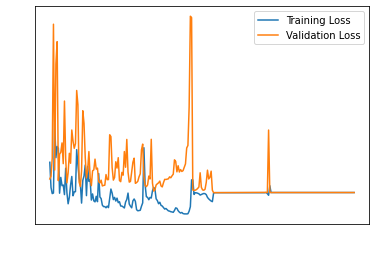

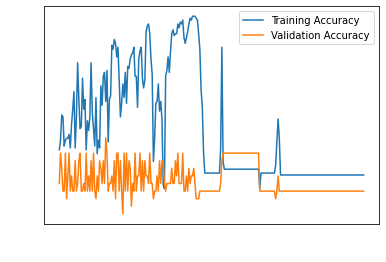

In [11]:
# Train the model and save the history
history = model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', color='white')
plt.ylabel('Loss', color='white')
plt.legend()
plt.tick_params(axis='x', colors='white')  # Change x and y tick label colors to black
plt.tick_params(axis='y', colors='white')  # Change x and y tick label colors to black
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', color='white')
plt.ylabel('Accuracy', color='white')
plt.legend()
plt.tick_params(axis='x', colors='white')  # Change x and y tick label colors to black
plt.tick_params(axis='y', colors='white')  # Change x and y tick label colors to black
plt.show()